# 手写数字识别作业
- 姓名：徐文斌
- 学号：2010234
- 专业：计算机科学与技术

### 实验要求
题目：基于KNN 的手写数字识别
实验条件：给定semeion手写数字数据集，给定kNN分类算法
实验要求：
1. 基本要求：编程实现kNN算法；给出在不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与weka机器学习包中的kNN分类结果进行对比
3. 提高要求：将实验过程结果等图示展出

### 实验环境说明
本实验使用的python解释器为python3.9，实验通过python-weka-wrapper3来调用weka的相关API。使用[该网站](https://fracpete.github.io/python-weka-wrapper3/install.html#windows-using-anaconda)提供的方法通过anaconda安装python-weka-wrapper3包。

### 导入需要的包

In [1]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import weka.core.jvm as jvm
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random
from weka.core.converters import Loader

### 导入数据集 semeion

In [2]:
def read_data(file_path):
    """
    从file_path对应的文件中读取数据，返回一个list[list[]]的data_set。
    data_set每个元素的前256个数字为像素点对应的值，最后一个数字为该图像的标注信息。
    """
    data_set = list()
    data_sign = list()
    with open(file_path, "r", encoding="UTF-8") as f:
        for line in f:
            single_data = list()
            words = line.split(" ")
            for i in range(256):
                single_data.append(float(words[i]))
            for i in range(10):
                if words[256 + i] == "1":
                    single_data.append(i)
                    break
            data_set.append(single_data)
    return data_set

In [3]:
data_set = read_data("semeion.data")
np.shape(data_set)

(1593, 257)

### 基本要求
编程实现kNN算法；给出不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（模板中采用的是普通方法分割训练集和测试集，作业中需要用留一法）

#### 首先定义距离函数
这里我选择使用欧氏距离

In [4]:
def distance(data1, data2):
    """
    输入两个向量，返回他们的欧氏距离
    """
    v1 = np.array(data1)
    v2 = np.array(data2)
    result = np.sqrt(sum((v1 - v2) ** 2))
    return result

In [5]:
vector1 = [1, 2, 3]
vector2 = [2, 3, 4]
distance(vector1, vector2)

1.7320508075688772

#### kNN函数定义

In [6]:
def kNN(data_set, k):
    """
    使用留一法，计算kNN算法预测的准确率，返回准确率
    """
    total = 0
    acc = 0
    t1 = time.time()
    for i in range(len(data_set)):
        now_test_data = data_set[i]
        distance_set = list()
        for j in range(len(data_set)):
            if i == j:
                continue
            now_train_data = data_set[j]
            now_distance = distance(now_test_data[:len(now_test_data) - 1], now_train_data[:len(now_train_data) - 1])
            distance_set.append([now_distance, now_train_data[-1]])
        distance_set = sorted(distance_set, key=lambda l: l[0], reverse=False)
        frequency_list = [0 for i in range(10)]
        for j in range(k):
            frequency_list[distance_set[j][1]] += 1
        max_frequency = max(frequency_list)
        category = 0
        for j in range(10):
            if frequency_list[j] == max_frequency:
                category = j
                break
        if now_test_data[-1] == category:
            acc += 1
        total += 1
    t2 = time.time()
    accRate = 1.0 * acc / total
    print("k={k_}时，测试个数为{total_}，正确个数为：{acc_}，准确率为：{accRate_}，用时：{time_}秒".format(k_=k, total_=total, acc_=acc, accRate_=accRate, time_=t2-t1))
    return accRate

#### 实验结果：

In [7]:
kNN(data_set, 1)
kNN(data_set, 3)
kNN(data_set, 5)

k=1时，测试个数为1593，正确个数为：1461，准确率为：0.9171374764595104，用时：114.22003412246704秒
k=3时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：115.93789005279541秒
k=5时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：113.37974286079407秒


0.903954802259887

### 算法优化
可以看到，实现的kNN算法运行耗时较长。上述实现的算法每次循环都要计算一个实例和其余所有实例的距离，这导致性能的下降，我们可以创建一个二维数组来存储程序运行过程中算出的两个实例之间的距离，从而当下次需要这个距离时，直接查表获得即可，这样应该可以节省一半的时间。优化算法如下：

In [8]:
def kNN_opt(data_set, k):
    """
    使用留一法，计算kNN算法预测的准确率，返回准确率，优化算法
    """
    total = 0
    acc = 0
    dist_table = np.zeros((len(data_set), len(data_set))) # 创建距离表
    t1 = time.time()
    for i in range(len(data_set)):
        now_test_data = data_set[i]
        distance_set = list()
        for j in range(len(data_set)):
            if i == j:
                continue
            now_train_data = data_set[j]
            if dist_table[i][j] != 0: # 若距离表有内容，直接取，否则计算距离并赋值
                now_distance = dist_table[i][j]
            else:
                now_distance = distance(now_test_data[:len(now_test_data) - 1], now_train_data[:len(now_train_data) - 1])
                dist_table[i][j] = dist_table[j][i] = now_distance
            distance_set.append([now_distance, now_train_data[-1]])
        distance_set = sorted(distance_set, key=lambda l: l[0], reverse=False)
        frequency_list = [0 for i in range(10)]
        for j in range(k):
            frequency_list[distance_set[j][1]] += 1
        max_frequency = max(frequency_list)
        category = 0
        for j in range(10):
            if frequency_list[j] == max_frequency:
                category = j
                break
        if now_test_data[-1] == category:
            acc += 1
        total += 1
    t2 = time.time()
    accRate = 1.0 * acc / total
    print("k={k_}时，测试个数为{total_}，正确个数为：{acc_}，准确率为：{accRate_}，用时：{time_}秒".format(k_=k, total_=total, acc_=acc, accRate_=accRate, time_=t2-t1))
    return accRate

#### 实验结果：
如下，优化后的算法运行时间大致为未优化算法运行时间的一半。

In [9]:
kNN_opt(data_set, 1)
kNN_opt(data_set, 3)
kNN_opt(data_set, 5)

k=1时，测试个数为1593，正确个数为：1461，准确率为：0.9171374764595104，用时：60.824899673461914秒
k=3时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：60.21754217147827秒
k=5时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：58.37820911407471秒


0.903954802259887

### 中级要求
与weka机器学习包中的kNN分类结果进行对比

#### 首先启动jvm虚拟机

In [10]:
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['D:\\Anaconda3\\envs\\py39\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'D:\\Anaconda3\\envs\\py39\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'D:\\Anaconda3\\envs\\py39\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'D:\\Anaconda3\\envs\\py39\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'D:\\Anaconda3\\envs\\py39\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


#### 生成ARFF格式的数据集

In [11]:
def gen_arff_file(data_set, obj_file_path):
    """
    利用传入的数据集生成weka可用的arff格式的文件，存到磁盘中
    """
    with open(obj_file_path, "w", encoding="UTF-8") as f:
        f.write("@RELATION digit\n\n")
        for i in range(1, 257):
            f.write(f"@ATTRIBUTE pix{i} REAL\n")
        f.write("@ATTRIBUTE class {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}\n\n")
        f.write("@DATA\n")
        for data in data_set:
            for ele in data[:-1]:
                f.write(f"{ele},")
            f.write(f"{data[-1]}\n")

#### 生成ARFF文件并将生成的数据load到内存中

In [12]:
gen_arff_file(data_set, "semeion.arff") # 生成arff文件
loader = Loader(classname="weka.core.converters.ArffLoader")
data = loader.load_file("semeion.arff") # 从arff文件获取数据
data.class_is_last() # 将数据的最后一个属性设置为class
data.num_instances

1593

#### weka_kNN函数定义

In [13]:
def weka_kNN(data_set, k, detail_info=False):
    t1 = time.time()
    classifier = Classifier(classname="weka.classifiers.lazy.IBk",
                        options=["-K", f"{k}"])
    classifier.build_classifier(data)
    e = Evaluation(data)
    e.crossvalidate_model(classifier, data, data_set.num_instances, Random(1)) # 这里把folders设置为data_set.num_instances就是留一法了
    t2 = time.time()
    if detail_info:
        print("------------------------------------------------------------------------------------------")
        print(classifier)
        print(e.summary())
        print(f"用时{t2 - t1}秒")
    else:
        print(f"k={k}时，weka包中knn模型训练手写体识别的准确率为：{e.percent_correct / 100}，用时{t2 - t1}秒")
    return e.percent_correct / 100

#### 实验结果：

In [14]:
weka_kNN(data, 1, detail_info=True)
weka_kNN(data, 3, detail_info=True)
weka_kNN(data, 5, detail_info=True)

------------------------------------------------------------------------------------------
IB1 instance-based classifier
using 1 nearest neighbour(s) for classification


Correctly Classified Instances        1460               91.651  %
Incorrectly Classified Instances       133                8.349  %
Kappa statistic                          0.9072
Mean absolute error                      0.0173
Root mean squared error                  0.1255
Relative absolute error                  9.6279 %
Root relative squared error             41.8064 %
Total Number of Instances             1593     

用时14.797832489013672秒
------------------------------------------------------------------------------------------
IB1 instance-based classifier
using 3 nearest neighbour(s) for classification


Correctly Classified Instances        1437               90.2072 %
Incorrectly Classified Instances       156                9.7928 %
Kappa statistic                          0.8912
Mean absolute error        

0.9070935342121783

### 高级要求
将实验过程结果等图示展出

#### 首先，获得k从1到30自己实现的kNN和调用weka的kNN算法的准确率

In [15]:
scores1 = list()
scores2 = list()
for k in range(1, 31):
    score = kNN_opt(data_set, k)
    scores1.append(score)
for k in range(1, 31):
    score = weka_kNN(data, k)
    scores2.append(score)

k=1时，测试个数为1593，正确个数为：1461，准确率为：0.9171374764595104，用时：60.90468883514404秒
k=2时，测试个数为1593，正确个数为：1402，准确率为：0.8801004394224733，用时：57.80709266662598秒
k=3时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：60.645740270614624秒
k=4时，测试个数为1593，正确个数为：1442，准确率为：0.9052102950408035，用时：61.507938861846924秒
k=5时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：60.96565556526184秒
k=6时，测试个数为1593，正确个数为：1441，准确率为：0.9045825486503453，用时：58.65621042251587秒
k=7时，测试个数为1593，正确个数为：1450，准确率为：0.9102322661644695，用时：61.725046157836914秒
k=8时，测试个数为1593，正确个数为：1446，准确率为：0.9077212806026366，用时：57.312278032302856秒
k=9时，测试个数为1593，正确个数为：1451，准确率为：0.9108600125549278，用时：56.79388451576233秒
k=10时，测试个数为1593，正确个数为：1440，准确率为：0.903954802259887，用时：56.71844553947449秒
k=11时，测试个数为1593，正确个数为：1448，准确率为：0.9089767733835531，用时：57.247565031051636秒
k=12时，测试个数为1593，正确个数为：1444，准确率为：0.90646578782172，用时：55.86270761489868秒
k=13时，测试个数为1593，正确个数为：1441，准确率为：0.9045825486503453，用时：54.42723488807678秒
k=14时，测试个数为1593，正确个数为：1441，准确率为：0.9045825486503453，用时：54.409

#### 然后画图显示结果

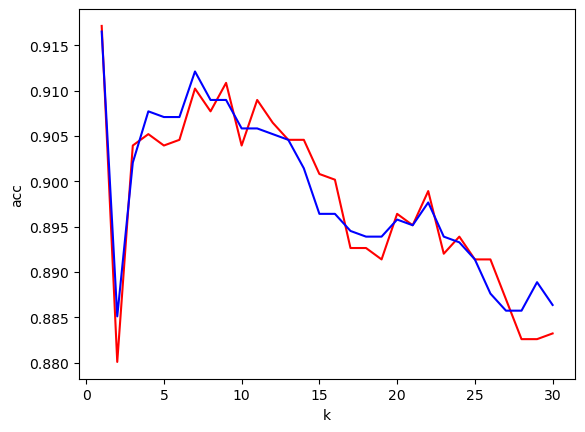

In [16]:
plt.xlabel("k")
plt.ylabel("acc")
# 红色为自己实现的，蓝色为weka包里的
plt.plot(range(1,31), scores1, 'r')
plt.plot(range(1,31), scores2, 'b')
plt.show()

### 实验结束，关闭jvm虚拟机

In [17]:
jvm.stop()